# Tutorial 5: Convergence model

**Romain Beucher** romain.beucher (at) anu.edu.au

In [1]:
from underworld import UWGeodynamics as GEO
from underworld import visualisation as vis

loaded rc file /home/romain/Projects/Project_UWGeodynamics/UWGeodynamics/UWGeodynamics/uwgeo-data/uwgeodynamicsrc


In [2]:
u = GEO.UnitRegistry

## Scaling

In [3]:
# Characteristic values of the system
half_rate = (0.5 * u.centimeter / u.year).to(u.meter / u.second)
model_length = 192 * u.kilometer
model_height = 68. * u.kilometer
surfaceTemp = 273.15 * u.degK
baseModelTemp = 823.15 * u.degK
bodyforce = (2800 * u.kilogram / u.metre**3 * 9.81 * u.meter / u.second**2)


KL = model_length
Kt = KL / half_rate
KM = bodyforce * KL**2 * Kt**2
KT = (baseModelTemp - surfaceTemp)

GEO.scaling_coefficients["[length]"] = KL
GEO.scaling_coefficients["[time]"] = Kt
GEO.scaling_coefficients["[mass]"]= KM
GEO.scaling_coefficients["[temperature]"] = KT

# Define the external geometry

The first step is to define the geometry of our problem, essentially a box on which we will apply some physical constraints and that will contain a set of materials. We can think of it as an "universe".
The "laws" and their effects are calculated on a mesh, that mesh discretized our universe into finite elements.

The geodynamics module allows you to quickly set up a model by creating a *Model* object.
A series of arguments are required to define a *Model*:

    - The number of elements in each direction elementRes=(nx, ny);
    - The minimum coordinates for each axis minCoord=(minX, minY)
    - The maximum coordinates for each axis maxCoord=(maxX, maxY)
    - A vector that defines the magnitude and direction of the gravity components gravity=(gx, gy)
 

In [4]:
Model = GEO.Model(elementRes=(192, 96), 
                  minCoord=(0. * u.kilometer, 0. * u.kilometer), 
                  maxCoord=(192. * u.kilometer, 68. * u.kilometer), 
                  gravity=(0.0, -9.81 * u.meter / u.second**2))

In [5]:
Model.outputDir="outputs_tutorial5"

# Add some Materials

Now that we have our "universe" (box, sand pit) ready, we need to fill it with some materials.
The *geodynamics* module is designed around that idea of materials, which are essentially a way to define physical properties across the Model domain.

A material (or a phase) is first defined by the space it takes in the box (its shape).

In [6]:
# Air Layer
air = Model.add_material(name="Air", shape=GEO.shapes.Layer2D(top=Model.top, bottom=42 * u.kilometer))
air.density = 1. * u.kilogram / u.metre**3
air.radiogenicHeatProd = 0.0
air.diffusivity = 1e-6 * u.metre**2 / u.second 
air.capacity = 100. * u.joule / (u.kelvin * u.kilogram)

In [7]:
# Sticky Air Layer
stickyAir = Model.add_material(name="Sticky Air", shape=GEO.shapes.Layer2D(top=air.bottom, bottom=40 * u.kilometer))
stickyAir.density = 1. * u.kilogram / u.metre**3
stickyAir.radiogenicHeatProd = 0.0
stickyAir.diffusivity = 1e-6 * u.metre**2 / u.second 
stickyAir.capacity = 100. * u.joule / (u.kelvin * u.kilogram)

In [8]:
# Uppercrust Layer
crust = Model.add_material(name="Crust", shape=GEO.shapes.Layer2D(top=40. * u.kilometer, bottom=Model.bottom))
crust.radiogenicHeatProd = 0.9 * u.microwatt / u.meter**3
crust.density  = GEO.LinearDensity(reference_density=2800. * u.kilogram / u.metre**3, thermalExpansivity=2.5e-5 / u.kelvin)
crust.diffusivity = 1e-6 * u.metre**2 / u.second 
crust.capacity    = 1000. * u.joule / (u.kelvin * u.kilogram)

# Limit the range of viscosities on that specific material
crust.minViscosity = 1e19 * u.pascal * u.second
crust.maxViscosity = 1e23 * u.pascal * u.second

## Passive Tracers

In [13]:
import numpy as np

npoints = 1000

coords = np.ndarray((npoints, 2))
coords[:, 0] = np.linspace(GEO.nd(Model.minCoord[0]), GEO.nd(Model.maxCoord[0]), npoints)
coords[:, 1] = GEO.nd(crust.top)

Model.add_passive_tracers(name="Surface", vertices=coords)

lines = []
for index in range(7):
    coords[:, 1] -= GEO.nd(5. * u.km)
    tracers_name = "line{0}".format(index + 1)
    Model.add_passive_tracers(name=tracers_name, vertices=coords)
    lines.append(tracers_name)


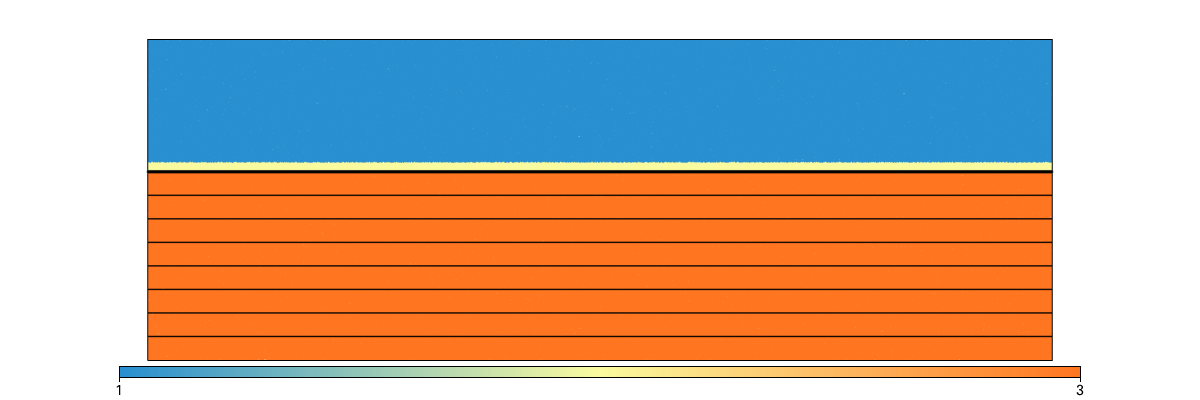

In [15]:
from underworld import visualisation as vis
Fig = vis.Figure(figsize=(1200,400))
Fig.Points(Model.Surface_tracers, pointSize=4.0)
for line in lines:
    Fig.Points(eval(f"Model.{line}_tracers"), pointSize=2.0)
Fig.Points(Model.swarm, Model.materialField, fn_size=2.0)
Fig.show()

# Define Viscosities

The rheology library contains some commonly used rheologies stored in a python dictionary structure. We can list the keys defining the rheologies as follows:

In [11]:
rh = GEO.ViscousCreepRegistry()

In [12]:
rh.Wet_Quartz_Dislocation_Tullis_et_al_2002

In [14]:
Model.minViscosity = 1e19 * u.pascal * u.second
Model.maxViscosity = 1e23 * u.pascal * u.second

air.viscosity = 1e19 * u.pascal * u.second
stickyAir.viscosity = 1e20 * u.pascal * u.second
crust.viscosity = rh.Wet_Quartz_Dislocation_Tullis_et_al_2002

# Define Plasticity

Plastic behavior is assigned using the same approach as for viscosities.

In [14]:
crust.plasticity = GEO.DruckerPrager(cohesion=20.* u.megapascal,
                                     cohesionAfterSoftening=10.*u.megapascal,
                                     frictionCoefficient=0.268,
                                     frictionAfterSoftening=0.035,
                                     epsilon1=0.25, epsilon2=1.25)

## Temperature Boundary Condition

In [15]:
Model.set_temperatureBCs(top=293.15 * u.degK, 
                         bottom=823.15 * u.degK, 
                         materials=[(air, 273.15 * u.degK ), (stickyAir, 273.15 * u.degK)])

## Velocity Boundary Conditions

In [16]:
Model.set_velocityBCs(left=[0.5 * u.centimeter / u.year, None],
                       right=[-0.5 * u.centimeter / u.year, None],
                       bottom=[None, 0.0])

## Initial Damage

In [17]:
Model.plasticStrain.data[:,0] = 0.
Model.plasticStrain.data[:,0] = np.random.rand(Model.plasticStrain.data.size)
Model.plasticStrain.data[:,0] *= (1.0 - np.cos(2.0*np.pi*Model.swarm.particleCoordinates.data[:,0]/(GEO.nd(Model.maxCoord[0] - Model.minCoord[0]))))**4
Model.plasticStrain.data[:,0] *= (1.0 - np.cos(2.0*np.pi*Model.swarm.particleCoordinates.data[:,1]/ GEO.nd(crust.top)))
Model.plasticStrain.data[:,0] /= 10 # It looks like there is a factor 10 missing in the paper
Model.plasticStrain.data[Model.swarm.particleCoordinates.data[:,1] > GEO.nd(crust.top)] = 0.


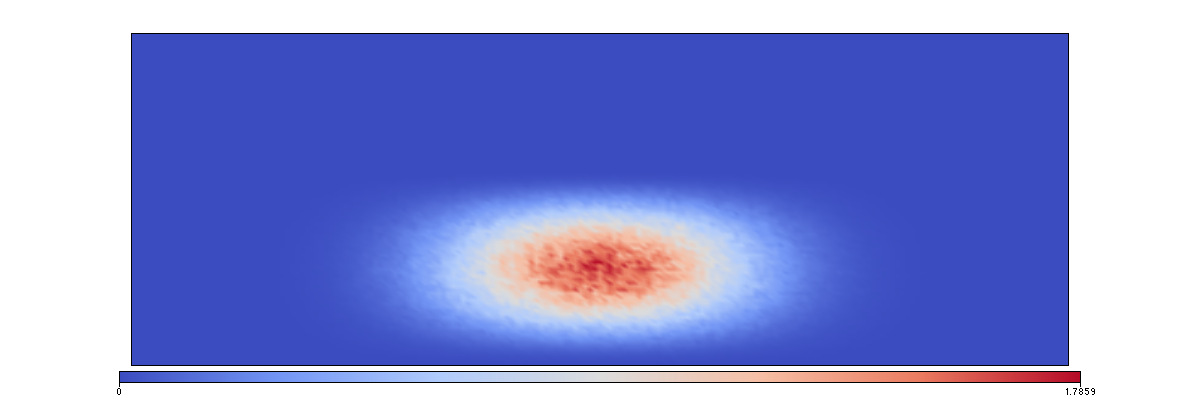

In [18]:
Fig = vis.Figure(figsize=(1200,400))
Fig.Surface(Model.mesh, Model.projPlasticStrain, colours="coolwarm")
Fig.show()

## Run Model

In [19]:
Model.init_model(temperature="steady-state", pressure="lithostatic")


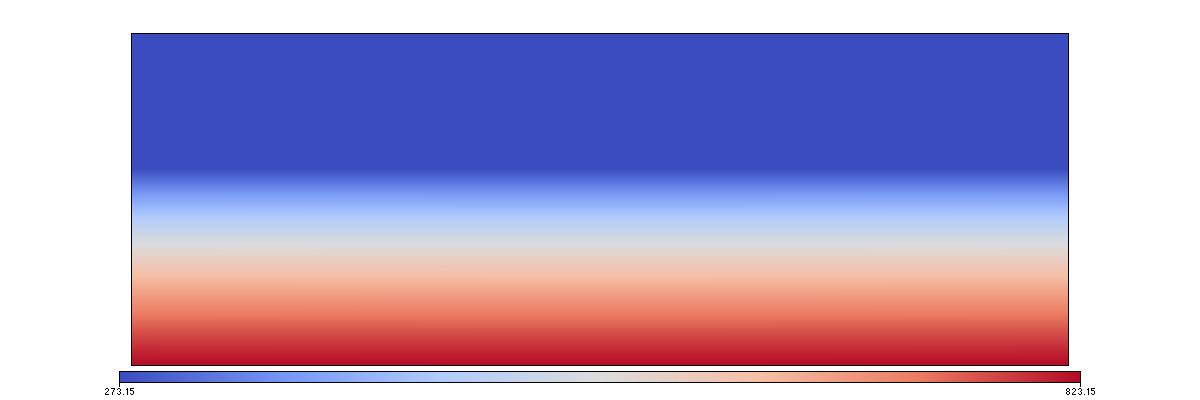

In [20]:
Fig = vis.Figure(figsize=(1200,400))
Fig.Surface(Model.mesh, GEO.dimensionalise(Model.temperature, u.degK), colours="coolwarm")
Fig.show()


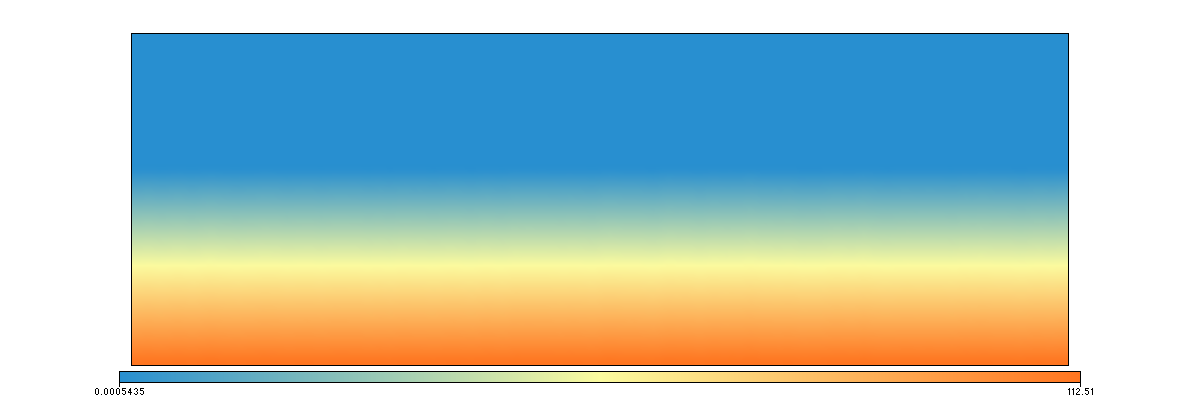

In [21]:
Fig = vis.Figure(figsize=(1200,400))
Fig.Surface(Model.mesh, GEO.dimensionalise(Model.pressureField, u.degK))
Fig.show()


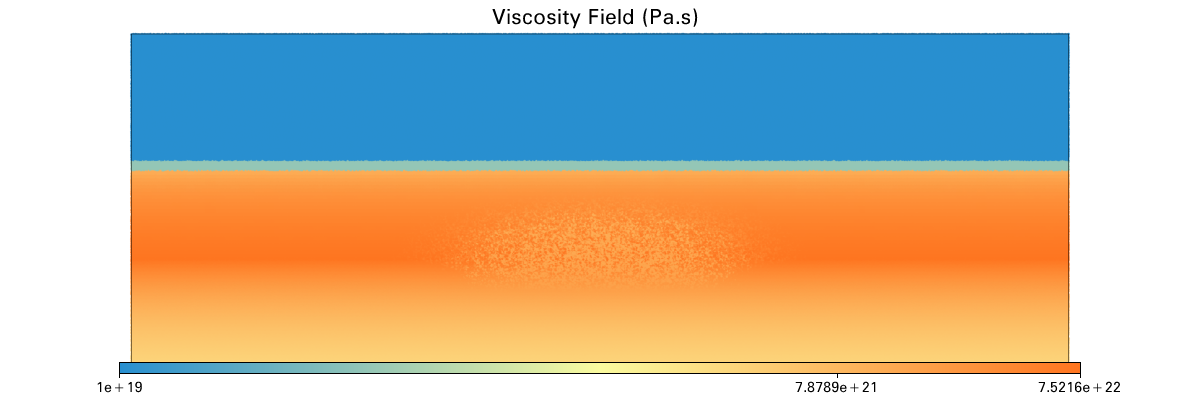

In [22]:
Fig = vis.Figure(figsize=(1200,400), title="Viscosity Field (Pa.s)", quality=3)
Fig.Points(Model.swarm, 
           GEO.dimensionalise(Model.viscosityField, u.pascal * u.second),
           logScale=True,
           fn_size=3.0)
Fig.show()

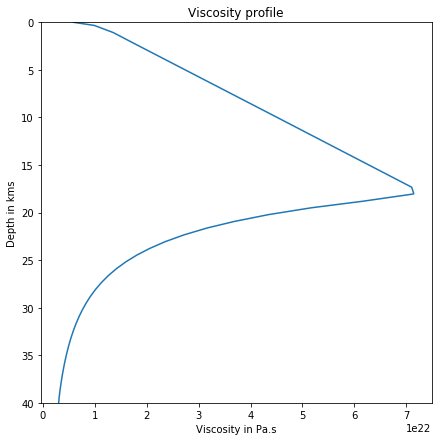

In [31]:
# Only run this when in serial. Will fail in parallel

if GEO.nProcs == 1:
    import pylab as plt

    distances, viscosities = GEO.extract_profile(Model.projViscosityField, 
                                                 line = [(10.* u.kilometer, 40. * u.kilometer), (10.* u.kilometer, Model.bottom)])
    distances, stresses = GEO.extract_profile(Model.projStressField, 
                                             line = [(10.* u.kilometer, 40. * u.kilometer), (10.* u.kilometer, Model.bottom)])


    Fig, (ax1) = plt.subplots(1,1,figsize=(7,7))
    ax1.plot(GEO.dimensionalise(viscosities, u.pascal * u.second), GEO.dimensionalise(distances, u.kilometer))
    ax1.set_xlabel("Viscosity in Pa.s")
    ax1.set_ylim(40, 0.)
    ax1.set_ylabel("Depth in kms")
    ax1.set_title("Viscosity profile")

In [24]:
Model.run_for(5.0 * u.megayears, checkpoint_interval=0.1*u.megayears)

Time:  0.0079221911602 megayear dt: 0.0079221911602 megayear
Time:  0.0158443823204 megayear dt: 0.0079221911602 megayear
Time:  0.0237665734806 megayear dt: 0.0079221911602 megayear
Time:  0.0316887646408 megayear dt: 0.0079221911602 megayear
Time:  0.039610955801 megayear dt: 0.0079221911602 megayear
Time:  0.0475331469612 megayear dt: 0.0079221911602 megayear
Time:  0.0554553381214 megayear dt: 0.0079221911602 megayear
Time:  0.0633775292816 megayear dt: 0.0079221911602 megayear
Time:  0.0712997204418 megayear dt: 0.0079221911602 megayear
Time:  0.079221911602 megayear dt: 0.0079221911602 megayear
Time:  0.0871441027622 megayear dt: 0.0079221911602 megayear
Time:  0.0950662939225 megayear dt: 0.0079221911602 megayear
Time:  0.1 megayear dt: 0.00493370607755 megayear
Time:  0.10792219116 megayear dt: 0.0079221911602 megayear
Time:  0.11584438232 megayear dt: 0.0079221911602 megayear
Time:  0.123766573481 megayear dt: 0.0079221911602 megayear
Time:  0.131688764641 megayear dt: 0.00792

Time:  1.0792219116 megayear dt: 0.0079221911602 megayear
Time:  1.08714410276 megayear dt: 0.0079221911602 megayear
Time:  1.09506629392 megayear dt: 0.0079221911602 megayear
Time:  1.1 megayear dt: 0.00493370607755 megayear
Time:  1.10792219116 megayear dt: 0.0079221911602 megayear
Time:  1.11584438232 megayear dt: 0.0079221911602 megayear
Time:  1.12376657348 megayear dt: 0.0079221911602 megayear
Time:  1.13168876464 megayear dt: 0.0079221911602 megayear
Time:  1.1396109558 megayear dt: 0.0079221911602 megayear
Time:  1.14753314696 megayear dt: 0.0079221911602 megayear
Time:  1.15545533812 megayear dt: 0.0079221911602 megayear
Time:  1.16337752928 megayear dt: 0.0079221911602 megayear
Time:  1.17129972044 megayear dt: 0.0079221911602 megayear
Time:  1.1792219116 megayear dt: 0.0079221911602 megayear
Time:  1.18714410276 megayear dt: 0.0079221911602 megayear
Time:  1.19506629392 megayear dt: 0.0079221911602 megayear
Time:  1.2 megayear dt: 0.00493370607755 megayear
Time:  1.207922191

Time:  2.16337752928 megayear dt: 0.0079221911602 megayear
Time:  2.17129972044 megayear dt: 0.0079221911602 megayear
Time:  2.1792219116 megayear dt: 0.0079221911602 megayear
Time:  2.18714410276 megayear dt: 0.0079221911602 megayear
Time:  2.19506629392 megayear dt: 0.0079221911602 megayear
Time:  2.2 megayear dt: 0.00493370607755 megayear
Time:  2.20792219116 megayear dt: 0.0079221911602 megayear
Time:  2.21584438232 megayear dt: 0.0079221911602 megayear
Time:  2.22376657348 megayear dt: 0.0079221911602 megayear
Time:  2.23168876464 megayear dt: 0.0079221911602 megayear
Time:  2.2396109558 megayear dt: 0.0079221911602 megayear
Time:  2.24753314696 megayear dt: 0.0079221911602 megayear
Time:  2.25545533812 megayear dt: 0.0079221911602 megayear
Time:  2.26337752928 megayear dt: 0.0079221911602 megayear
Time:  2.27129972044 megayear dt: 0.0079221911602 megayear
Time:  2.2792219116 megayear dt: 0.0079221911602 megayear
Time:  2.28714410276 megayear dt: 0.0079221911602 megayear
Time:  2.

Time:  3.24753314696 megayear dt: 0.0079221911602 megayear
Time:  3.25545533812 megayear dt: 0.0079221911602 megayear
Time:  3.26337752928 megayear dt: 0.0079221911602 megayear
Time:  3.27129972044 megayear dt: 0.0079221911602 megayear
Time:  3.2792219116 megayear dt: 0.0079221911602 megayear
Time:  3.28714410276 megayear dt: 0.0079221911602 megayear
Time:  3.29506629392 megayear dt: 0.0079221911602 megayear
Time:  3.3 megayear dt: 0.00493370607755 megayear
Time:  3.30792219116 megayear dt: 0.0079221911602 megayear
Time:  3.31584438232 megayear dt: 0.0079221911602 megayear
Time:  3.32376657348 megayear dt: 0.0079221911602 megayear
Time:  3.33168876464 megayear dt: 0.0079221911602 megayear
Time:  3.3396109558 megayear dt: 0.0079221911602 megayear
Time:  3.34753314696 megayear dt: 0.0079221911602 megayear
Time:  3.35545533812 megayear dt: 0.0079221911602 megayear
Time:  3.36337752928 megayear dt: 0.0079221911602 megayear
Time:  3.37129972044 megayear dt: 0.0079221911602 megayear
Time:  3

Time:  4.33168876464 megayear dt: 0.0079221911602 megayear
Time:  4.3396109558 megayear dt: 0.0079221911602 megayear
Time:  4.34753314696 megayear dt: 0.0079221911602 megayear
Time:  4.35545533812 megayear dt: 0.0079221911602 megayear
Time:  4.36337752928 megayear dt: 0.0079221911602 megayear
Time:  4.37129972044 megayear dt: 0.0079221911602 megayear
Time:  4.3792219116 megayear dt: 0.0079221911602 megayear
Time:  4.38714410276 megayear dt: 0.0079221911602 megayear
Time:  4.39506629392 megayear dt: 0.0079221911602 megayear
Time:  4.4 megayear dt: 0.00493370607755 megayear
Time:  4.40792219116 megayear dt: 0.0079221911602 megayear
Time:  4.41584438232 megayear dt: 0.0079221911602 megayear
Time:  4.42376657348 megayear dt: 0.0079221911602 megayear
Time:  4.43168876464 megayear dt: 0.0079221911602 megayear
Time:  4.4396109558 megayear dt: 0.0079221911602 megayear
Time:  4.44753314696 megayear dt: 0.0079221911602 megayear
Time:  4.45545533812 megayear dt: 0.0079221911602 megayear
Time:  4.

1